In [1]:
import pandas as pd 
from datastreams.datastream import Streamer
from pool import AMMPool, AMMPoolHistory, CPMM, AMMWithBaulking, OraclePool
import matplotlib as mpl
from matplotlib import pyplot as plt
import sysconfig

In [2]:
print(sysconfig.get_python_version())

3.10


**Get Uni trades stream**  

In [3]:
query_size = 20000

# instantiate Streamer object. 
# Note - unlike the cow queries, univ3 does not require multiple streamer instantations because the swaps field path is reset each iteration. 
# If the Cow queries were updated to use the same method, we could use the same streamer object for all queries.
univ3_ds = Streamer('https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum')

# get a query field path from the query dictionary which is automatically populated in the Streamer object
uni_swaps_fp = univ3_ds.queryDict.get('swaps')

# define query path and parameters 
uni_swaps_qp = uni_swaps_fp(
        first=query_size, 
        orderBy='timestamp',
        orderDirection='asc',
        where = {'timestamp_gt':164373600, 'pool': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', 'amountInUSD_gt': 100, 'amountOutUSD_gt': 100,} 
        )

# run query
uni_swaps_df = univ3_ds.runQuery(uni_swaps_qp)

FIELD - swaps


In [4]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['swaps_timestamp'].min()
last_timestamp_uni = uni_swaps_df['swaps_timestamp'].max()
print(f'first timestamp: {first_timestamp_uni} \nlast timestamp: {last_timestamp_uni}')

first timestamp: 1643673723 
last timestamp: 1647770398


**get chainlink pricing to value pools**

In [5]:
# load streamer class
chain_ds = Streamer('https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph')
chain_price_feed = "ETH/USD"

In [49]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
chain_fp = chain_ds.queryDict.get('prices')

# add parameters to the settlements_qp.
chain_qp = chain_fp(
    first= 20000,
    orderBy='timestamp',
    orderDirection='asc',
    where = {'timestamp_gt':1643673600, 'assetPair': chain_price_feed}
    )

# run query
chain_df = chain_ds.runQuery(chain_qp)

FIELD - prices


In [50]:
# drop prices_id, endpoint. 
chain_df = chain_df.drop(['prices_id', 'endpoint'], axis=1)
# divide prices_price by 1e8 to get the price in USD
chain_df['prices_price'] = chain_df['prices_price'] / 10 ** 8

In [51]:
# Find the first and last value in the timestamp column
first_timestamp_chain = chain_df['prices_timestamp'].min()
last_timestamp_chain = chain_df['prices_timestamp'].max()
print(f'first timestamp: {first_timestamp_chain} \nlast timestamp: {last_timestamp_chain}')

first timestamp: 1643676926 
last timestamp: 1669719731


In [52]:
timestamps = pd.DataFrame({'prices_timestamp': range(first_timestamp_chain, last_timestamp_chain + 1)})

In [53]:
# left merge chain_df with empty timestamps_df
chain_df = pd.merge(timestamps, chain_df, on='prices_timestamp', how='left')

In [54]:
# Forward-fill missing values
chain_df.fillna(method='ffill', inplace=True)
# reset index
price_s = chain_df.set_index("prices_timestamp")["prices_price"]  # small chainlink prices?

**get initialization price**

In [55]:
# chainlink at first_timestamp of uni trades:
initialization_df = chain_df[chain_df["prices_timestamp"] == first_timestamp_chain]
initilizatioin_price = initialization_df.iloc[0,2]

# initialize 100m USDC supply reserve amount
USDC_reserves_USD = 100000000

In [56]:
token0_start = int(USDC_reserves_USD/initilizatioin_price)
print(f"Token 0 WETH initial reserves: \t{token0_start}")

token1_start = USDC_reserves_USD
print(f"Token 1 USDC initial reserves :\t{token1_start}")

Token 0 WETH initial reserves: 	37156
Token 1 USDC initial reserves :	100000000


**1.Simple AMM. SWAP ALL** 

In [57]:
# Create an instance of AMMPoolHistory 
feedlot1 = AMMPoolHistory(token0_start, token1_start)

In [58]:
# Instantiate the CPMM object with the AMMPool object
cpmm = CPMM(pool=feedlot1)
cpmm_SI_flow = AMMWithBaulking(cpmm, price_s)

In [59]:
# check that the price sources all start the same
print(f'price initialized by chainilnk: {initilizatioin_price}')
print(f'feedlot initialized price: {feedlot1.reserves[1] / feedlot1.reserves[0]}')
print(f'cpmm initialized price: {cpmm_SI_flow.amm.pool.reserves[1] / cpmm_SI_flow.amm.pool.reserves[0]}')

price initialized by chainilnk: 2691.31586673
feedlot initialized price: 2691.355366562601
cpmm initialized price: 2691.355366562601


In [60]:
uni_swaps_df['swaps_amountIn'] = uni_swaps_df['swaps_amountIn'].astype('float64')

In [61]:
uni_swaps_df['swaps_tokenIn_id'].unique()

array(['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
       '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], dtype=object)

In [62]:
# get minimum swaps_amountIn value
uni_swaps_df['swaps_amountIn'].min()

102385645.0

In [63]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    if row['swaps_timestamp'] < 1643676926: continue # wait until we have chainlink prices

    # check if tokenIn is WETH or USDC. Apply decimal conversion accordingly.
    match row['swaps_tokenIn_id']:
        case '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2':  # check if tokenIn is WETh
            token = 0
            amt = row['swaps_amountIn'] / 10**18
        case '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':  # check if tokenIn is USDC
            token = 1
            amt = row['swaps_amountIn'] / 10**6


    # Run the swap function on the AMM pool
    amt0, amt1 = cpmm_SI_flow.maybe_market_order_sell(amt,token,row['swaps_timestamp'])
    # print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

In [64]:
results1_df = pd.DataFrame(feedlot1.history)

In [65]:
price_s = price_s * 1000

In [66]:
results1_df

,ts,reserve0,reserve1
0,0,37156.000000,1.000000e+08
1,1643677266,37148.000000,1.000234e+08
2,1643677266,37156.000000,1.000000e+08
3,1643677640,37064.000000,1.002498e+08
4,1643677829,37018.000000,1.003748e+08
...,...,...,...
26330,1647769224,37144.499375,1.067832e+08
26331,1647770347,37120.499375,1.068544e+08
26332,1647770366,37051.499375,1.070560e+08
26333,1647770398,37050.499375,1.070603e+08


In [67]:
# merge results1_df with chain_df on timestamp
results1_merged_df = pd.merge(results1_df, chain_df, left_on='ts', right_on='prices_timestamp', how='inner')

In [68]:
results1_merged_df['reserve0_usd'] = results1_merged_df['reserve0'] * results1_merged_df['prices_price']

In [69]:
results1_merged_df['tvl'] = results1_merged_df['reserve0_usd'] + results1_merged_df['reserve1']

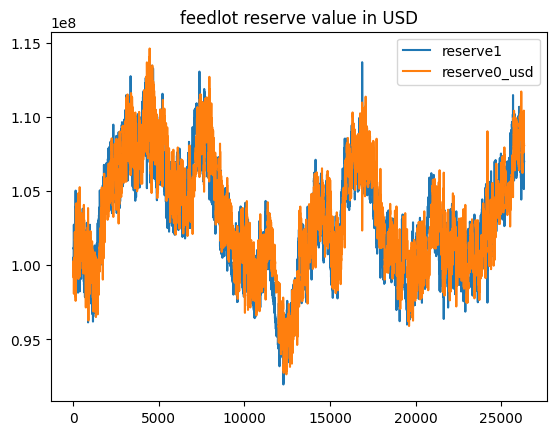

In [70]:
results1_merged_df[['reserve1', 'reserve0_usd']].plot()
plt.title('feedlot reserve value in USD')
plt.show();

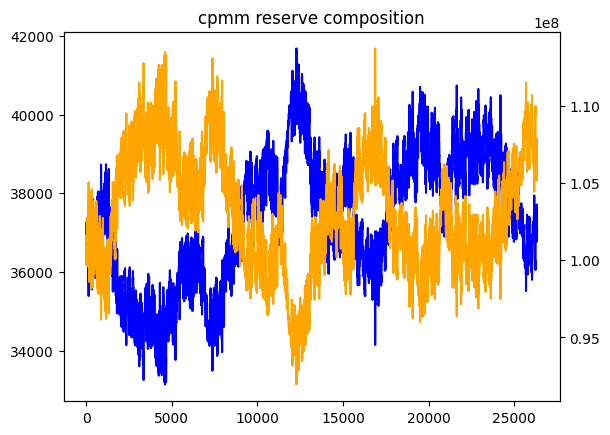

In [71]:
ax0 =results1_merged_df["reserve0"].plot(color='blue', label='USDC reserve')
ax1 = ax0.twinx()
ax1 =results1_merged_df["reserve1"].plot(color='orange', label='WETH reserve')
plt.title('cpmm reserve composition')
plt.show();

**OraclePool AMM**

**get cow trades for oracle pricing** 

In [72]:
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

# get COW trades 

trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades
trades_qp = trades_fp(
    first=20000,
    orderBy='timestamp',
    orderDirection='asc',
    where={'timestamp_gt':1643673600, 'sellToken':'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
           'buyToken':'0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


In [73]:
# Set query size large enough to retrieve all tokens in the graph
query_size = 10000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size,
)

# run query
token_df = cow_ds.runQuery(token_qp)


FIELD - tokens


In [74]:
# Merge1 on sell token address.  x = sell token 
merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

In [75]:
# Merge2 on buy token address.  y = buy token 
cow_df = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

In [76]:
# calculate buy and sell amounts from the correct decimal 
cow_df['sell_amount'] = cow_df.apply(lambda x: x['trades_sellAmount'] / (10**x['tokens_decimals_x']), axis=1)
cow_df['buy_amount'] = cow_df.apply(lambda x: x['trades_buyAmount'] / (10**x['tokens_decimals_y']), axis=1)

In [77]:
# calculate COW price defined sell amount / buy amount
cow_df['cow_price'] = cow_df['sell_amount'] / cow_df['buy_amount']

In [78]:
# Find the first and last value in the timestamp column
first_timestamp_cow = chain_df['prices_timestamp'].min()
last_timestamp_cow = chain_df['prices_timestamp'].max()

In [79]:
oracle_dict = [{"ts": row["trades_timestamp"], "p": row["cow_price"]} for _, row in cow_df.iterrows()]

**Oracle pool simulation**

In [80]:
# Create an instance of AMMPoolHistory 
feedlot2 = AMMPoolHistory(token0_start, token1_start)

In [81]:
feedlot3 = OraclePool(feedlot2, oracle_dict)

In [82]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    if row['swaps_timestamp'] < 1643676926: continue # wait until we have chainlink prices

    # check if tokenIn is WETH or USDC. Apply decimal conversion accordingly.
    match row['swaps_tokenIn_id']:
        case '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2':  # check if tokenIn is WETh
            token = 0
            amt = row['swaps_amountIn'] / 10**18
        case '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':  # check if tokenIn is USDC
            token = 1
            amt = row['swaps_amountIn'] / 10**6


    # Run the swap function on the AMM pool
    amt0, amt1 = feedlot3.market_order_sell(amt,token,row['swaps_timestamp'])
    # print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

In [83]:
results2_df = pd.DataFrame(feedlot2.history)

In [84]:
# merge results1_df with chain_df on timestamp
results2_merged_df = pd.merge(results2_df, chain_df, left_on='ts', right_on='prices_timestamp', how='inner')

# calculate usd value of reserve0, which is the WETH reserves
results2_merged_df['reserve0_usd'] = results2_merged_df['reserve0'] * results2_merged_df['prices_price']

# calculate tvl
results2_merged_df['tvl'] = results2_merged_df['reserve0_usd'] + results2_merged_df['reserve1']

In [85]:
results1_merged_df

,ts,reserve0,reserve1,prices_timestamp,prices_assetPair_id,prices_price,reserve0_usd,tvl
0,1643677266,37148.000000,1.000234e+08,1643677266,ETH/USD,2691.315867,9.997700e+07,2.000004e+08
1,1643677266,37156.000000,1.000000e+08,1643677266,ETH/USD,2691.315867,9.999853e+07,1.999985e+08
2,1643677640,37064.000000,1.002498e+08,1643677640,ETH/USD,2691.315867,9.975093e+07,2.000007e+08
3,1643677829,37018.000000,1.003748e+08,1643677829,ETH/USD,2691.315867,9.962713e+07,2.000019e+08
4,1643677886,37022.981790,1.003612e+08,1643677886,ETH/USD,2691.315867,9.964054e+07,2.000018e+08
...,...,...,...,...,...,...,...,...
26329,1647769224,37144.499375,1.067832e+08,1647769224,ETH/USD,2913.523259,1.082214e+08,2.150046e+08
26330,1647770347,37120.499375,1.068544e+08,1647770347,ETH/USD,2916.590000,1.082653e+08,2.151197e+08
26331,1647770366,37051.499375,1.070560e+08,1647770366,ETH/USD,2916.590000,1.080640e+08,2.151200e+08
26332,1647770398,37050.499375,1.070603e+08,1647770398,ETH/USD,2916.590000,1.080611e+08,2.151215e+08


In [86]:
results2_merged_df

,ts,reserve0,reserve1,prices_timestamp,prices_assetPair_id,prices_price,reserve0_usd,tvl
0,1643677266,37148.000000,1.000234e+08,1643677266,ETH/USD,2691.315867,9.997700e+07,2.000004e+08
1,1643677640,37058.000000,1.002732e+08,1643677640,ETH/USD,2691.315867,9.973478e+07,2.000079e+08
2,1643677829,37013.000000,1.003982e+08,1643677829,ETH/USD,2691.315867,9.961367e+07,2.000118e+08
3,1643677886,37017.981790,1.003843e+08,1643677886,ETH/USD,2691.315867,9.962708e+07,2.000114e+08
4,1643678003,37025.325801,1.003640e+08,1643678003,ETH/USD,2691.315867,9.964685e+07,2.000108e+08
...,...,...,...,...,...,...,...,...
19986,1647769224,50739.657049,6.378166e+07,1647769224,ETH/USD,2913.523259,1.478312e+08,2.116128e+08
19987,1647769224,50729.657049,6.381131e+07,1647769224,ETH/USD,2913.523259,1.478020e+08,2.116133e+08
19988,1647770347,50705.657049,6.388255e+07,1647770347,ETH/USD,2916.590000,1.478876e+08,2.117702e+08
19989,1647770366,50636.657049,6.408412e+07,1647770366,ETH/USD,2916.590000,1.476864e+08,2.117705e+08


In [87]:
# count the number of swaps in results1 and results 2
print(f"Number of swaps in CPMM: {len(results1_merged_df)}")
print(f"Number of swaps in OraclePool: {len(results2_merged_df)}")

Number of swaps in CPMM: 26334
Number of swaps in OraclePool: 19991


In [88]:
# convert timestamp to datetime
results1_merged_df['prices_timestamp'] = pd.to_datetime(results1_merged_df['prices_timestamp'], unit='s')
results2_merged_df['prices_timestamp'] = pd.to_datetime(results2_merged_df['prices_timestamp'], unit='s')

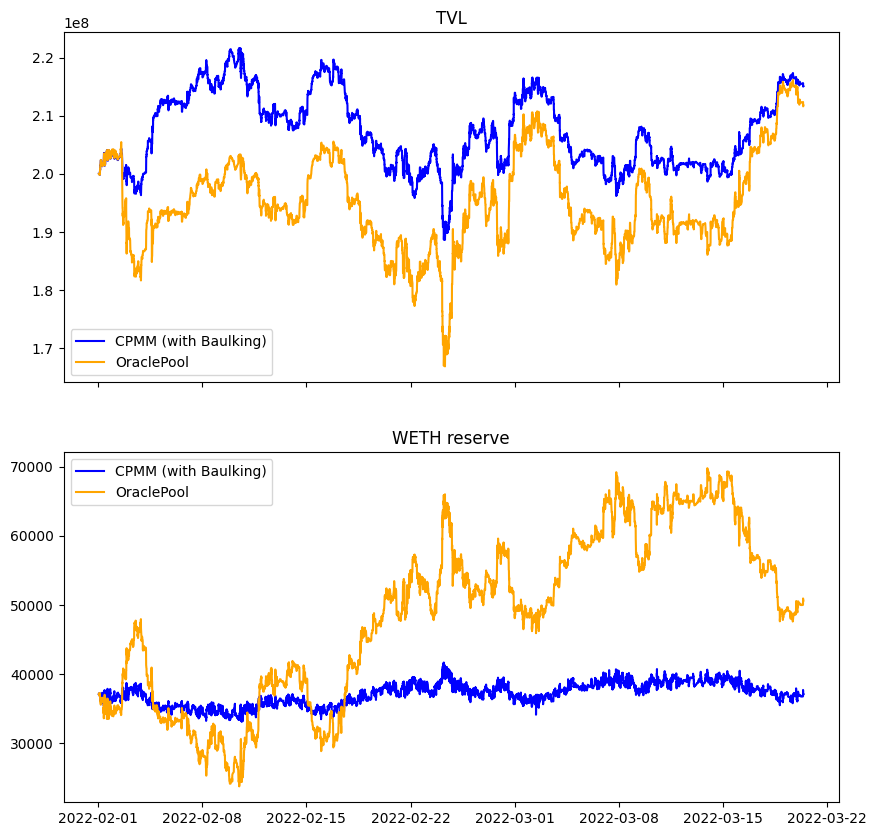

In [89]:
# plot subplots of merged dfs tvl
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax0.plot(results1_merged_df['prices_timestamp'], results1_merged_df['tvl'], color='blue', label='CPMM (with Baulking)')
ax0.plot(results2_merged_df['prices_timestamp'], results2_merged_df['tvl'], color='orange', label='OraclePool')
ax0.set_title('TVL')
ax0.legend()
ax1.plot(results1_merged_df['prices_timestamp'], results1_merged_df['reserve0'], color='blue', label='CPMM (with Baulking)')
ax1.plot(results2_merged_df['prices_timestamp'], results2_merged_df['reserve0'], color='orange', label='OraclePool')
ax1.set_title('WETH reserve')
ax1.legend()
plt.show();

In [ ]:
# plot subplots of merged dfs tvl
plt.plot(results1_merged_df['prices_timestamp'], results1_merged_df['tvl'], color='blue', label='CPMM (with Baulking)')
plt.plot(results2_merged_df['prices_timestamp'], results2_merged_df['tvl'], color='orange', label='OraclePool')
plt.plot(results1_merged_df['prices_timestamp'], results1_merged_df['reserve0'], color='blue', label='CPMM (with Baulking)')
plt.plot(results2_merged_df['prices_timestamp'], results2_merged_df['reserve0'], color='orange', label='OraclePool')
plt.set_title('WETH reserve')
plt.legend()
plt.show();